Frederico Furst Bittencourt

2022/09/17

Copied and modified from https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html (em 2002/jun/07).

## Intro

This file was created as part of the 

Tentative titles:

- The prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates and Chaos and Hyperchaos in the Triple Mass-Spring System Dynamic Response

- Chaos and Hyperchaos in the Triple Mass-Spring Dynamic Response and its application to the prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates

# Generalized n-Discrete Mass-Spring Model

#### Imports and Libraries

In [420]:
!pip install nolds
import nolds
import numpy as np
# Plot the solution that was generated
import matplotlib.pyplot as plt
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint
# ks entropy
!pip install EntropyHub
import EntropyHub as EH

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model Specification

In [421]:
forca_inicial = 0.0
forca_final = -1.0
tempo_inicial = 5.0
tempo_final = 10.0

In [422]:
n=5 # n > 2 seria a condicao de teste

In [423]:
# Parameter values
# Masses:
# m1 = 2.0
m = 2.0/n
# Spring constants
# k1 = 5.0
k = 2.5*n
# Natural lengths
# L1 = 1.0
L = 4.0/n
# Friction coefficients
# b1 = 0.6
b = 9.5/n

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
xizesys = [ (n+2)*L/2 if n%2==0 else 0.0 for n in range(2*n) ]
xizesys_desl = xizesys[:-2]

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 25.0
numpoints = 1000

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

In [424]:
xizesys_desl

[0.8, 0.0, 1.6, 0.0, 2.4000000000000004, 0.0, 3.2, 0.0]

## Entrada de Degrau de Força em $x_3$

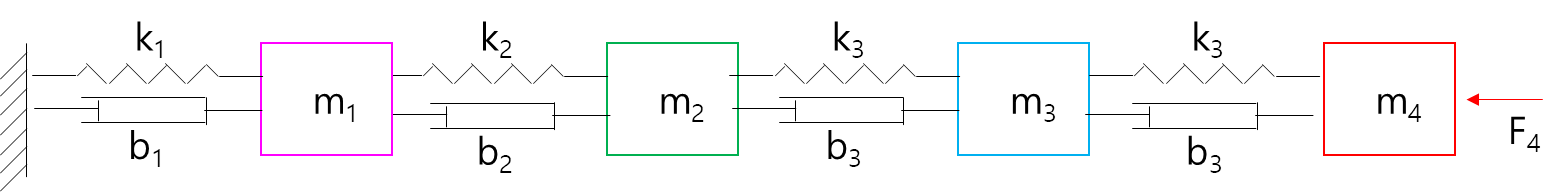

### Entradas

#### Degrau de Força de Entrada

In [425]:
# degrau de forca
def degrau_forca(t):
    if t <= 5.0:
        forca = forca_inicial
    else:
        forca = forca_final
    return forca

#### Campo Vetorial

In [426]:
len(range(2,2*n-2))

6

In [427]:
def degrau_forca_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
            # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
    if n > 2:
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
    f.append( w[2*n-1] )
    f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + degrau_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [428]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys

# Call the ODE solver.
wsol = odeint(degrau_forca_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicada e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for n-Discrete Spring-Mass System degrau forca')

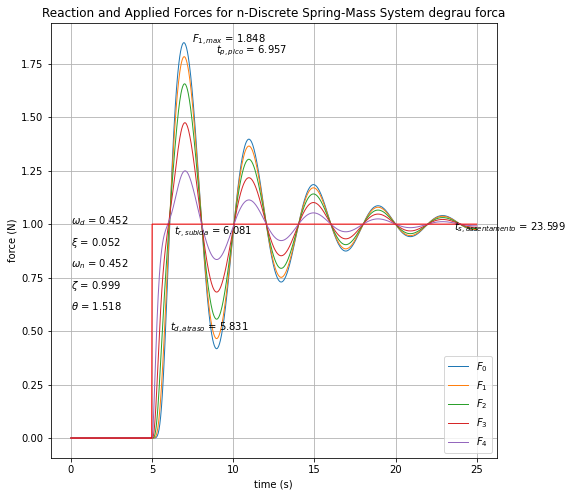

In [429]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), 'r', linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for n-Discrete Spring-Mass System degrau forca')

In [430]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 5-Discrete Spring-Mass System degrau forca')

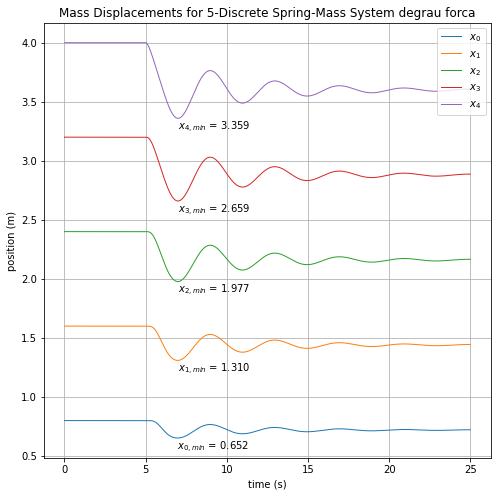

In [431]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 5-Discrete Spring-Mass System degrau forca')

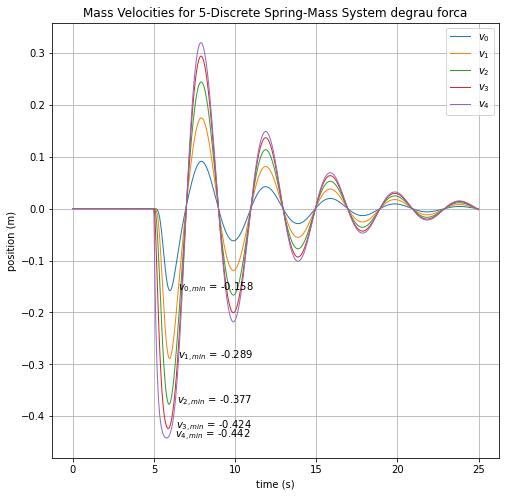

In [432]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 5-Discrete Spring-Mass System degrau forca')

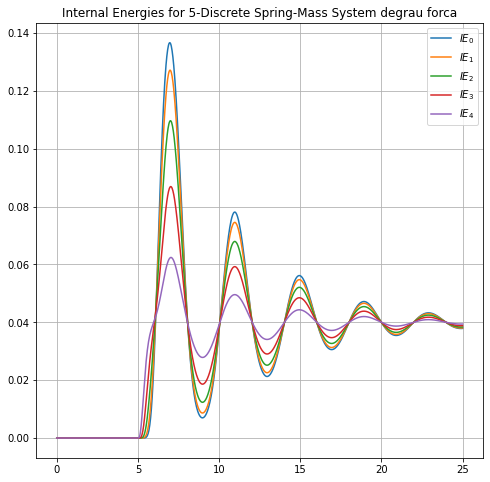

In [433]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

In [434]:
len(KE)

5

Text(0.5, 1.0, 'Kinetic Energies for 5-Discrete Spring-Mass System degrau forca')

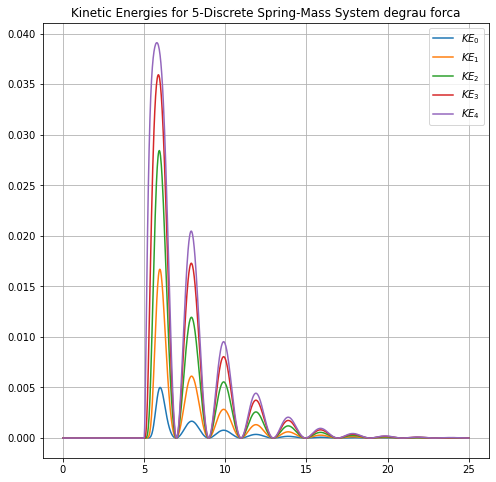

In [435]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Total Energy for 5-Discrete Spring-Mass System degrau forca')

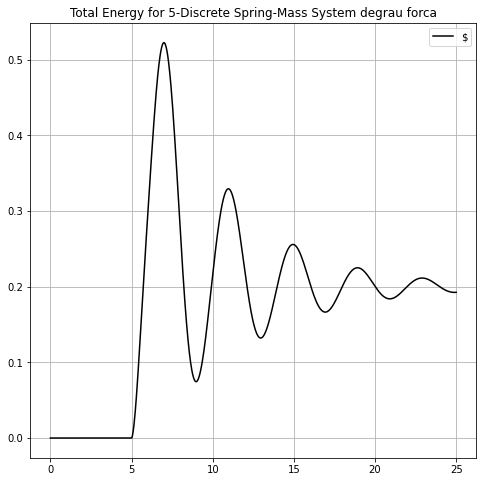

In [436]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Extremos

In [437]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print(np.array([
  EH.K2En(ax[i], m=4) for i in range(n)
]))

[[ 0.15274449  0.00278465 -0.10537124 -0.29332668]
 [ 0.15760918  0.00323179 -0.07288998 -0.2285047 ]
 [ 0.11802888  0.01185319 -0.06405275 -0.20866446]
 [ 0.11223765  0.01243449 -0.0657495  -0.2536612 ]
 [ 0.16544867  0.0266929  -0.07899065 -0.28218874]]
[[array([0.23083073, 0.14561721, 0.11705623, 0.09969834])
  array([0.23311111, 0.18506081, 0.15998295, 0.14231047, 0.12880668])]
 [array([0.23173116, 0.14547526, 0.11957477, 0.09828429])
  array([0.2369049 , 0.18790333, 0.16246334, 0.14415334, 0.13065932])]
 [array([0.23239901, 0.14348629, 0.11826108, 0.10013837])
  array([0.24349149, 0.19299861, 0.167201  , 0.14855208, 0.13439688])]
 [array([0.23159377, 0.14061467, 0.11537683, 0.10260847])
  array([0.25410611, 0.20157432, 0.17513261, 0.15604847, 0.14083066])]
 [array([0.22405438, 0.14033864, 0.11099735, 0.10001746])
  array([0.2692993 , 0.2152433 , 0.18706018, 0.16740785, 0.15147424])]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """



## Entrada de Rampa em Força em $x_3$

### Entradas

#### Rampa de Força de Entrada

In [438]:
# rampa de forca
def rampa_forca(t):
    if t < tempo_inicial:
        forc = forca_inicial
    elif t >= tempo_inicial and t <= tempo_final:
        # forc = 5.0-1.0*t
        forc = forca_inicial+(forca_final-forca_inicial)/(10.0-5.0)*(t-5.0)
    else:
        forc = forca_final
    return forc

#### Campo Vetorial

In [439]:
def rampa_forca_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
            # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
    if n > 2:
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
    f.append( w[2*n-1] )
    f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + rampa_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [440]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
# w0 = [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#       x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16]

w0 = xizesys

# Call the ODE solver.
wsol = odeint(rampa_forca_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicadas e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

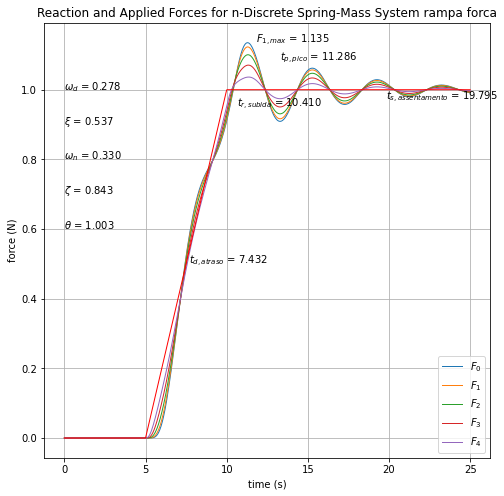

In [441]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ rampa_forca(t) for t in at ]), 'r', linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

In [442]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 5-Discrete Spring-Mass System rampa forca')

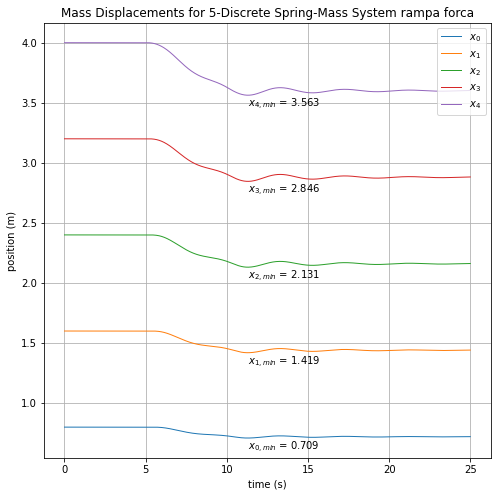

In [443]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 5-Discrete Spring-Mass System rampa forca')

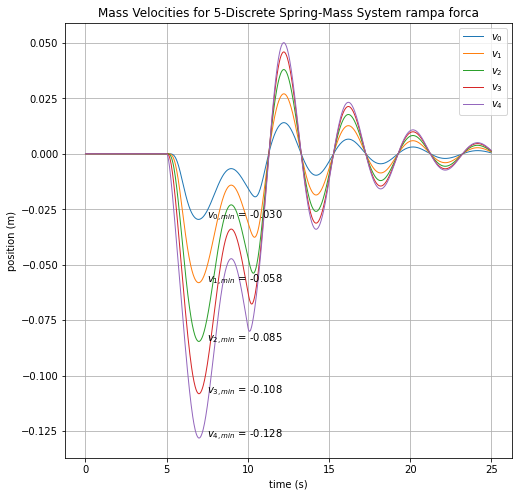

In [444]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 5-Discrete Spring-Mass System rampa forca')

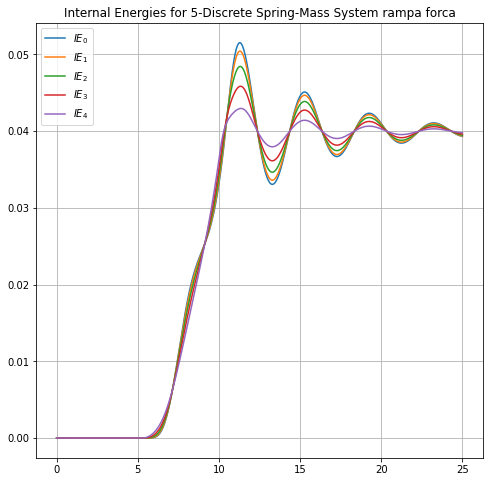

In [445]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Kinetic Energies for 5-Discrete Spring-Mass System rampa forca')

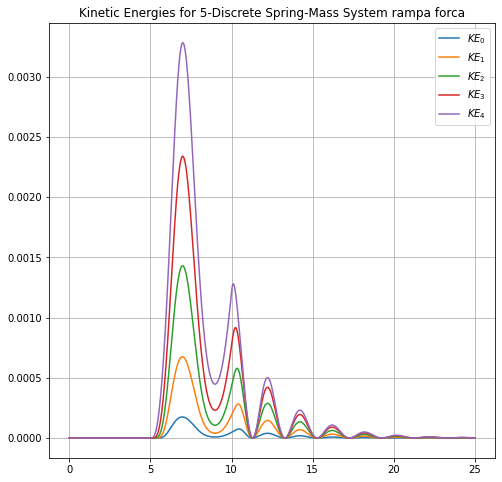

In [446]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Total Energy for 5-Discrete Spring-Mass System rampa forca')

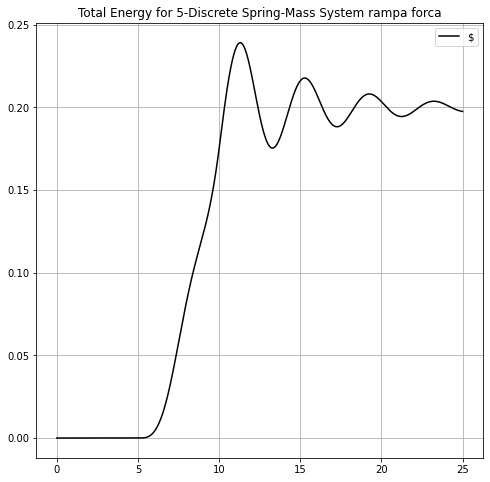

In [447]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend((r'$E_T$'))
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Extremos

In [448]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print(np.array([
  EH.K2En(ax[i], m=4) for i in range(n)
]))

[[ 0.15788692  0.01776745 -0.09939852 -0.26995695]
 [ 0.1414753   0.01529748 -0.06313405 -0.2917678 ]
 [ 0.12477221  0.01608308 -0.05693657 -0.2552068 ]
 [ 0.11653752  0.01599628 -0.07064532 -0.2557145 ]
 [ 0.15385993  0.02958457 -0.05845124 -0.24961655]]
[[array([0.16436385, 0.10500737, 0.08722278, 0.06390343])
  array([0.36137337, 0.30660119, 0.27603854, 0.25298184, 0.23732114])]
 [array([0.16099795, 0.10255099, 0.08603106, 0.06681584])
  array([0.36584985, 0.31144571, 0.28108976, 0.25791833, 0.24124841])]
 [array([0.15474404, 0.10030251, 0.08057524, 0.06964585])
  array([0.3737017 , 0.32012574, 0.28957413, 0.26715689, 0.24918367])]
 [array([0.14814161, 0.10118442, 0.07251518, 0.06558189])
  array([0.3860961 , 0.33293414, 0.30089467, 0.27984757, 0.26208351])]
 [array([0.13525815, 0.09087119, 0.07505206, 0.05611199])
  array([0.39997397, 0.34937342, 0.31902521, 0.29595816, 0.27980868])]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


## Entrada de Rampa em Deslocamento em $x_3$

### Entradas

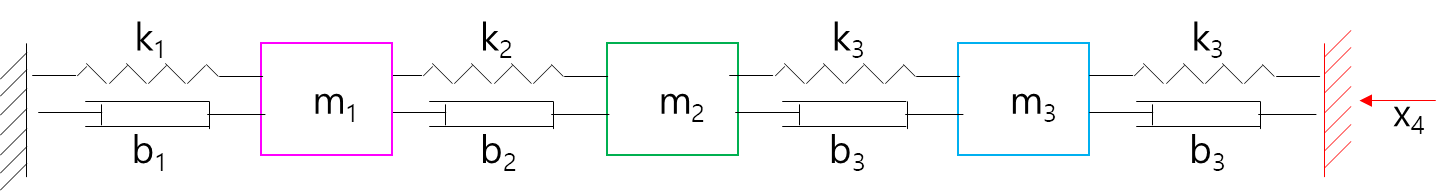

#### Rampa em Degrau de Entrada

In [449]:
def rampa_disp(t):
    return rampa_forca(t)*(n/k)+(n*L)

Criando uma derivada da função rampa definida de forma simbólica.

In [450]:
from sympy import Piecewise
from sympy import symbols

In [451]:
tempo = symbols('t')
rampa_desl = Piecewise(
    (forca_inicial*(n/k)+(n*L), (tempo > 0.0) & (tempo < tempo_inicial)),
    (n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial)*(tempo-tempo_inicial))+n*L, \
      (tempo >= tempo_inicial) & (tempo < tempo_final)),
    (forca_final*(n/k)+(n*L), (tempo >= tempo_final))
)
rampa_desl_derivada = rampa_desl.diff(tempo)
rampa_desl.diff(tempo)

Piecewise((0, (t > 0.0) & (t < 5.0)), (-0.08, (t >= 5.0) & (t < 10.0)), (0, t >= 10.0))

In [452]:
def deriv_desl(t):
     if t < tempo_inicial:
         dd = 0.0
     elif t >= tempo_inicial and t <= tempo_final:
         # forc = 5.0-1.0*t
         dd = n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial))
     else:
         dd = 0.0
     return dd

In [453]:
rampa_desl

Piecewise((4.0, (t > 0.0) & (t < 5.0)), (4.4 - 0.08*t, (t >= 5.0) & (t < 10.0)), (3.6, t >= 10.0))

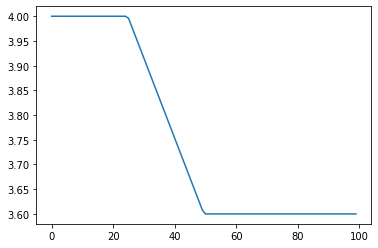

In [454]:
plt.plot([ rampa_disp(t) for t in np.linspace(0.0,20.0,100)])

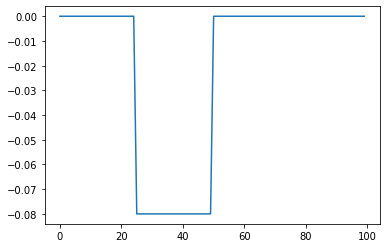

In [455]:
plt.plot([ deriv_desl(t) for t in np.linspace(0.0,20.0,100)])

#### Campo Vetorial

In [456]:
def rampa_desl_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    if n > 2:
        f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
    elif n==2:
        f.append( (-b * w[1] + b * (deriv_desl(t) - w[1]) - k * (w[0] - L) + k * (rampa_disp(t) - w[0] - L ) )/ m )
    if n > 2:
        for i in range(2,2*n-4):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
        f.append( w[2*n-3] )
        f.append( (-b * (w[2*n-3] - w[2*n-5]) + b * (deriv_desl(t) - w[2*n-3]) - k * (w[2*n-4] - w[2*n-6] - L) + k * (rampa_disp(t) - w[2*n-4] -L) ) / m )
    # y15,
    # (-b * (y15 - y14) + b * (deriv_desl(t) - y15) - k * (x15 - x14 - L) + k * (rampa_disp(t) - x15 - L) ) / m,
    return f

### Saídas

#### Unpacking

In [457]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys_desl # [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
     #  x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15,] #  x16, y16]

# Call the ODE solver.
wsol = odeint(rampa_desl_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    ETt = 0.0
    for i in range(n):
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2
        elif i==n-1:
            IE[i].append(k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2)
            KE[i].append(m*deriv_desl(t1)**2/2)
            ax[i].append(rampa_disp(t1))
            ay[i].append(deriv_desl(t1))
            ETt += k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2+m*deriv_desl(t1)**2/2
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2
    ET.append(ETt)

#### Forças de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for 5-Discrete Spring-Mass System rampa desl')

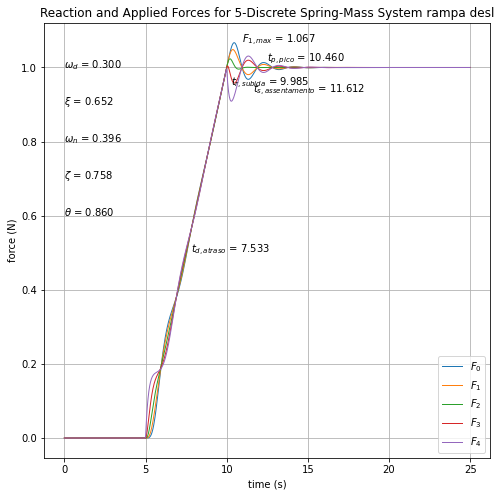

In [458]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System rampa desl')

In [459]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 5-Discrete Spring-Mass System rampa desl')

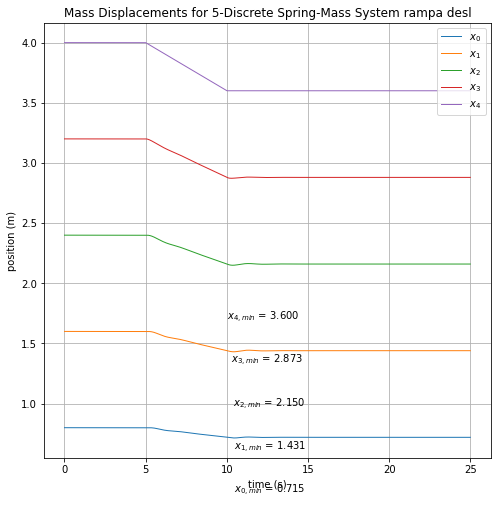

In [460]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)/2-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 5-Discrete Spring-Mass System rampa desl')

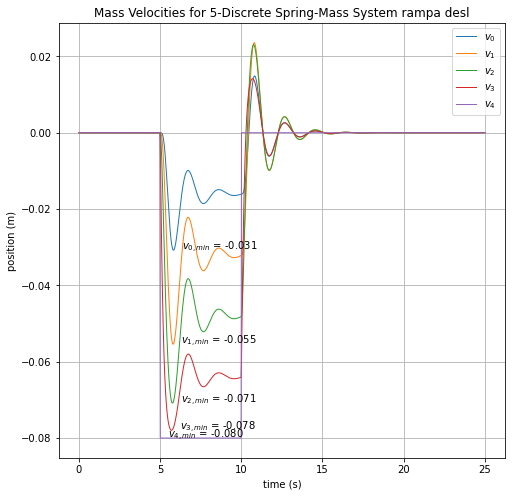

In [461]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Energias

Text(0.5, 1.0, 'Internal Energies for5-Discrete Spring-Mass System rampa desl')

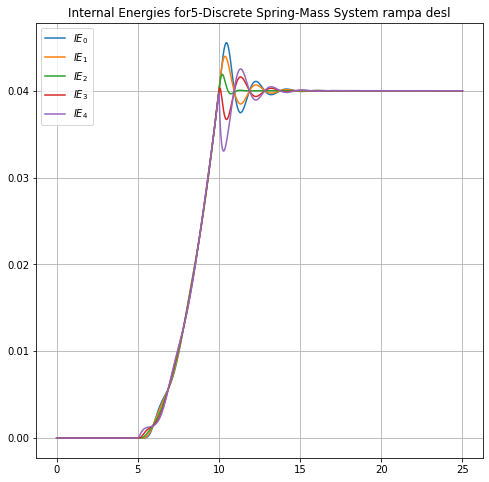

In [462]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for'+str(n)+'-Discrete Spring-Mass System rampa desl')

Text(0.5, 1.0, 'Kinetic Energies for 5-Discrete Spring-Mass System rampa desl')

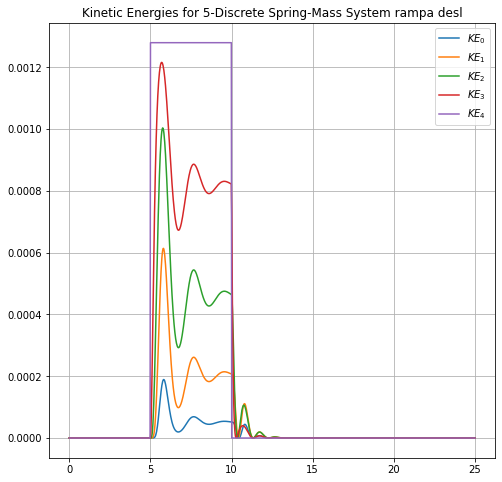

In [463]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa desl')

Text(0.5, 1.0, 'Total Energy for 5-Discrete Spring-Mass System rampa desl')

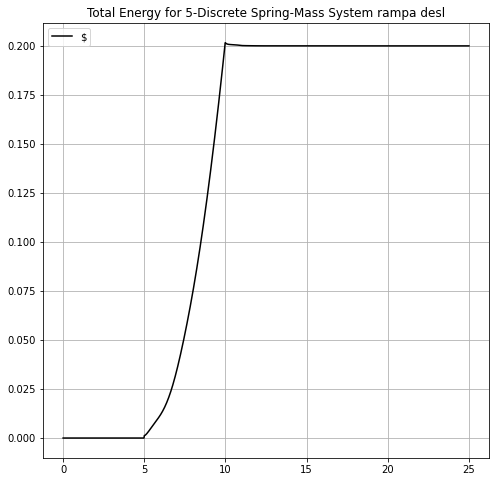

In [464]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Extremos

In [465]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print(np.array([
  EH.K2En(ax[i], m=4) for i in range(n)
]))

[[ 0.12913425 -0.0008803  -0.09623737 -0.28217947]
 [ 0.12393076 -0.00261822 -0.10858212 -0.2716893 ]
 [ 0.15856765 -0.00931441 -0.10653197 -0.30242124]
 [ 0.15720722  0.00046135 -0.06508176 -0.2979823 ]
 [ 0.13233434  0.0144215  -0.20707393 -0.38723484]]
[[array([0.0472471 , 0.0276057 , 0.01652306, 0.01261325])
  array([0.43588589, 0.41577048, 0.40444982, 0.39782198, 0.39283566])]
 [array([0.02479618, 0.03837869, 0.01895921, 0.01364903])
  array([0.43602603, 0.42534719, 0.40933221, 0.40164469, 0.39619987])]
 [array([0.02259064, 0.00954672, 0.00870507, 0.02931746])
  array([0.43505105, 0.42533315, 0.42129193, 0.41764047, 0.40557406])]
 [array([0.02299614, 0.00881144, 0.00536629, 0.00589539])
  array([0.43335135, 0.42349965, 0.4197844 , 0.41753775, 0.41508345])]
 [array([0.33286327, 0.12205814, 0.09776763, 0.08577624])
  array([0.03336136, 0.0239157 , 0.02116771, 0.01919614, 0.01761821])]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
